In [10]:
%reload_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba

import utils as ut
import main as ma
import plot_utils as pu

m_p = 1.67262192369e-27 # proton mass
e = 1.602176634e-19 # elementary charge

A magnetic dipole is given by

$$
    \mathbf{B}(\mathbf{r}) = \frac{\mu_0}{4\pi} \left( \frac{3(\boldsymbol{\mu}\cdot\mathbf{r})\mathbf{r}}{r^5} -  \frac{\boldsymbol{\mu}}{r^3} \right)
$$

Two dipoles aligned make a magnetic bottle. We create our magnetic bottle along the $z$ direction.

In [13]:
mu = 10000.0  * np.array([0.0, 0.0, 1.0]) 
dz = 10

@numba.njit
def B_bottle(r):
    B1 = ut.B_dipole(r, mu, r0=np.array([0,0,dz]))
    B2 = ut.B_dipole(r, mu, r0=np.array([0,0,-dz]))
    return B1 + B2

Let's get the magnetic field lines

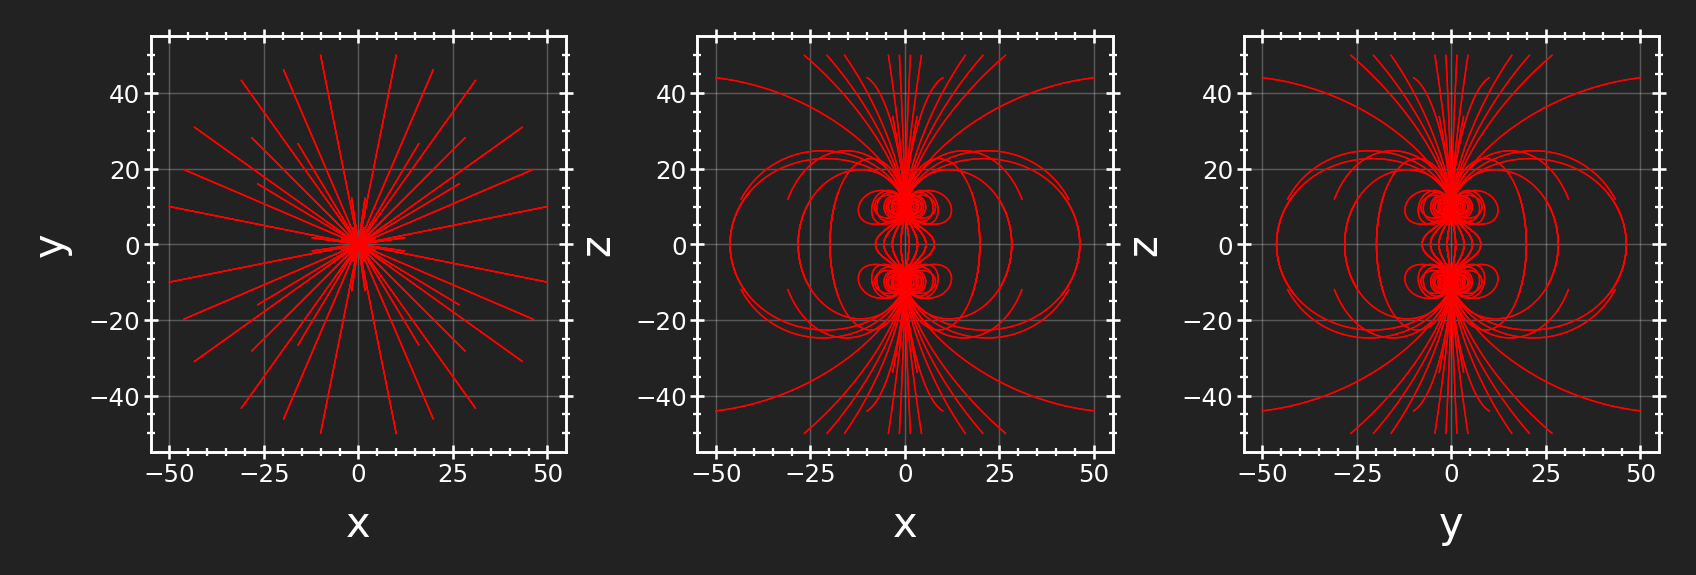

In [17]:
R = 10
M = 10
xs = np.linspace(-R, R, M)
ys = np.linspace(-R, R, M)

Fig = pu.Figure(fig_size=540, ratio=3.7, subplots=(1, 3))
axs = Fig.axes_flat
fs = Fig.fs

flines_list = []

rdm = 1
lw=0.1
for x in xs:
    for y in ys:
        r = x**2 + y**2
        if r > R**2:
            continue
        pos = np.array([x, y, 0], dtype=np.float32)
        flines = ut.trace_field_line(B_bottle, pos, 
                                        steps=5000, step_size=0.02, 
                                        direction='both',
                                        lim=50)
        
        flines_list.append(flines)

        pairs = [(0,1), (0,2), (1,2)]
        labels = ['x', 'y', 'z']
        for i, ax in enumerate(axs):
            ax.plot(flines[:,pairs[i][0]], flines[:,pairs[i][1]], 'r', lw=lw*fs)
            ax.set_aspect('equal')
            ax.set_xlabel(labels[pairs[i][0]], color='w')
            ax.set_ylabel(labels[pairs[i][1]], color='w')
            

Only if you want to save them, uncomment

In [137]:
# K = len(flines_list)
# arrays_obj = np.array(flines_list, dtype=object)
# savefold = f'../results/magnetic_field_lines_dz_{dz}_num_{K}_R_{R}/'
# if not os.path.exists(savefold):
#     os.makedirs(savefold)

# np.save(savefold + 'flines_list', arrays_obj)

Integrate Helium-4 trajectories. We first initialize the simulation

In [21]:
N = 120  # number of particles

x_vel = np.random.normal(loc=0, scale=20, size=N)
y_vel = np.random.normal(loc=0, scale=20, size=N)
z_vel = np.random.normal(loc=120, scale=20, size=N)
z_vel = [z_v * np.random.choice([-1, 1]) for z_v in z_vel]

rho_lim = 5
z_lim = 1
x_pos = np.random.uniform(-rho_lim, rho_lim, N)
y_pos = np.random.uniform(-rho_lim, rho_lim, N)
z_pos = np.random.uniform(-z_lim, z_lim, N)

rs = list(np.array([x_pos, y_pos, z_pos]).T)
vs = list(np.array([x_vel, y_vel, z_vel]).T)

And we run it

In [22]:
m = 4.0 * m_p
q = 2.0 * e

bodies = [ma.Body(m, q, r_, v_) for r_, v_ in zip(rs, vs)]

sim = ma.Simulation(bodies, B_bottle)

T = 0.3
dt = 0.5e-4

sim.run_simulation(T, dt)

99.98%

Filter particles that get jeeted away

In [23]:
positions = sim.positions
velocities = sim.velocities

velocity_diff = np.diff(velocities, axis=0)
v_mag_diff = np.linalg.norm(velocity_diff, axis=1)

threshold = 1e2
exceeds_threshold = np.any(v_mag_diff > threshold, axis=0)
particles_to_exclude = np.where(exceeds_threshold)[0]
print(particles_to_exclude)

filtered_positions = np.delete(positions, particles_to_exclude, axis=2)

[  1   3   4  14  35  68  82  85 115]


Plot the resulting trajectories

[(-10, 10), (-10, 10), (-10, 10)]


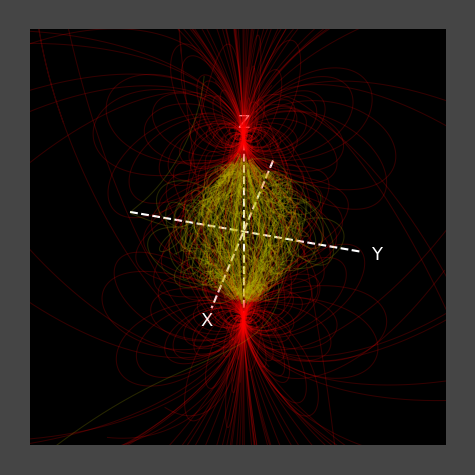

In [24]:
Fig3D = pu.Figure3D(lims=10,
                                azimuth=40, polar=15)
ax = Fig3D.ax
fs = Fig3D.fs

Fig3D.create_ticks()

lw=0.1

M = 1000
L = positions.shape[0]
step = L//M
for flines in flines_list:
    ax.plot(flines[:,0], flines[:,1], flines[:,2], 'r', lw=lw*fs, alpha=0.2)

for i in range(filtered_positions.shape[2]):
    x = filtered_positions[::step,0,i]
    y = filtered_positions[::step,1,i]
    z = filtered_positions[::step,2,i]
    ax.plot(x, y, z, 'y', lw=lw*fs, alpha=0.2)

Save results

In [25]:
pos_coarse = filtered_positions[::step, :, :]
N_ = pos_coarse.shape[2]

savefold = f'../results/particles_N_{N_}_T_{T}/'
if not os.path.exists(savefold):
    os.makedirs(savefold)

np.save(savefold + 'paths', pos_coarse)